In [1]:
import seaborn as sns
from time import time
import random
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score

In [3]:
import tensorflow as tf
from tensorflow.keras import models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Embedding, MaxPooling1D
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.layers import LSTM, Bidirectional, Conv1D, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

In [5]:
from train_utils import *

In [6]:
train_data = pd.read_csv('trainingdata.csv')

In [7]:
train_data.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,8/7/2015 9:54,6.296970e+17,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,8/7/2015 9:54,6.296970e+17,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,8/7/2015 9:54,6.296970e+17,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,8/7/2015 9:54,6.296970e+17,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,8/7/2015 9:54,6.296970e+17,NaN,Arizona


In [8]:
df = train_data[['sentiment', 'text']]
print(df.shape)
df.columns = ['Sentiment', 'Text']
df['Sentiment'] = df['Sentiment'].map({'Negative':0, 'Neutral':2, 'Positive':1})
df = df.sample(frac=1, random_state=0)
df.reset_index(drop=True, inplace=True)
df.head()

(13871, 2)


,Sentiment,Text
0,0,RT @NoChristie16: #ChrisChristie blasts sanctu...
1,1,"Even the media doesn't get it, No one won las..."
2,0,RT @RWSurferGirl: We the American people pick ...
3,0,"RT @jamiaw: ""The purpose of the military is to..."
4,0,#GOPDebate Maybe they were right to try &amp; ...


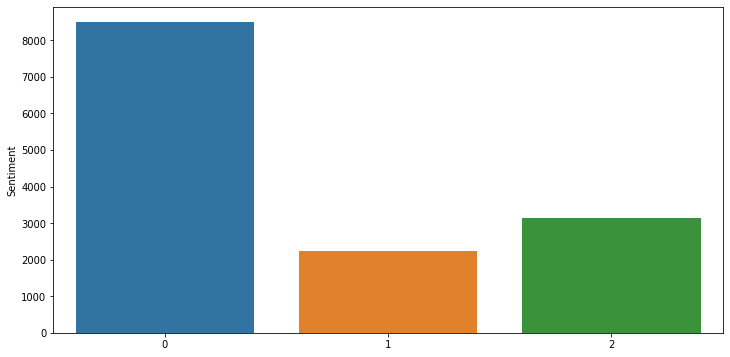

In [9]:
plt.figure(figsize=(12,6))
sns.barplot(df['Sentiment'].value_counts().index, df['Sentiment'].value_counts());

In [10]:
text_cleaner = TextCleaner(df)
clean_df = text_cleaner.get_clean_text()
clean_df.head()

,Sentiment,Text,Clean_Text
0,0,RT @NoChristie16: #ChrisChristie blasts sanctu...,chrischristie blast sanctuary city nose nj gop...
1,1,"Even the media doesn't get it, No one won las...",even medium last night men base carly star
2,0,RT @RWSurferGirl: We the American people pick ...,american_people_pick next president fox news g...
3,0,"RT @jamiaw: ""The purpose of the military is to...",purpose military kill_people break_things_mike...
4,0,#GOPDebate Maybe they were right to try &amp; ...,gopdebate maybe right try amp destroy obama st...


In [11]:
X = clean_df['Clean_Text']
y = pd.get_dummies(clean_df['Sentiment'])
# y = clean_df['Sentiment']

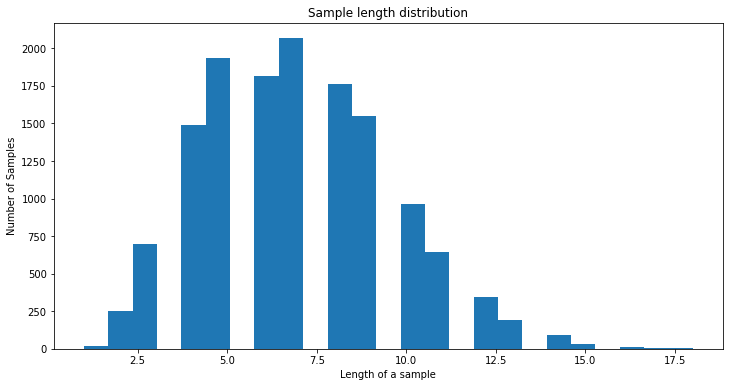

In [12]:
plt.figure(figsize=(12,6))
plt.hist([len(s.split()) for s in X], 25)
plt.xlabel('Length of a sample')
plt.ylabel('Number of Samples')
plt.title('Sample length distribution')
plt.show();

In [13]:
no_samples = X.shape[0]
no_class = len(clean_df['Sentiment'].unique())
no_words_per_sample = np.median([len(s.split()) for s in X])
print('Ratio of number of samples / number of words per sample: ' + str(no_samples / no_words_per_sample))

Ratio of number of samples / number of words per sample: 1981.5714285714287


In [14]:
def split_data(X, y):
    random.seed(0)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

    for sub_df in [x_train, x_val, x_test, y_train, y_val, y_test]:
        sub_df.reset_index(drop=True, inplace=True)

    return x_train, x_val, x_test, y_train, y_val, y_test

In [15]:
train_texts, val_texts, test_texts, train_labels, val_labels, test_labels = split_data(X, y)

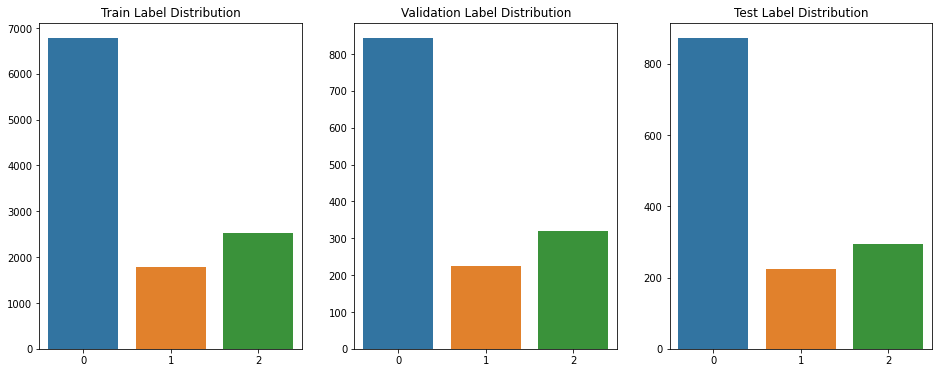

In [16]:
fig, axs = plt.subplots(ncols=3, figsize=(16,6))
sns.barplot(train_labels.idxmax(axis=1).value_counts().index, train_labels.idxmax(axis=1).value_counts(), ax=axs[0])
# sns.barplot(train_labels.value_counts().index, train_labels.value_counts(), ax=axs[0])
axs[0].set_title('Train Label Distribution')
sns.barplot(val_labels.idxmax(axis=1).value_counts().index, val_labels.idxmax(axis=1).value_counts(), ax=axs[1])
# sns.barplot(val_labels.value_counts().index, val_labels.value_counts(), ax=axs[1])
axs[1].set_title('Validation Label Distribution')
sns.barplot(test_labels.idxmax(axis=1).value_counts().index, test_labels.idxmax(axis=1).value_counts(), ax=axs[2])
# sns.barplot(test_labels.value_counts().index, test_labels.value_counts(), ax=axs[2 ])
axs[2].set_title('Test Label Distribution')
plt.show();

In [17]:
max_sequence_length = min(int(np.percentile([len(s.split()) for s in train_texts.append(
    [val_texts, test_texts], ignore_index=True)], 95)), 600)
    
class_weights = compute_class_weight('balanced', np.unique(train_labels.idxmax(axis=1)), train_labels.idxmax(axis=1))
class_weights_dict = dict(zip(np.unique(train_labels.idxmax(axis=1)), class_weights))
joblib.dump(class_weights_dict, FILE_DIR + 'class_weights.pkl')

['./artifacts/class_weights.pkl']

In [18]:
def generate_ngrams_embeddings_sequence(model_list):
    if 'MLP' in model_list:
        print('Computing ngram vectors...')
        global train_ng, val_ng, test_ng, train_labels
        train_ng, train_labels, val_ng, test_ng = ngram_vectorize(train_texts, train_labels, val_texts, test_texts)
    if 'CNN_BiLSTM' in model_list:
        print('Computing embedding matrix...')
        global train_vec, val_vec, test_vec
        train_vec, val_vec, test_vec = generate_embedding_matrix(train_texts, val_texts, test_texts)
    if 'LSTM' in model_list:
        print('Generating sequence vectors...')
        global train_seq, val_seq, test_seq, word_index
        train_seq, val_seq, test_seq, word_index = sequence_vectorize(train_texts, val_texts, test_texts, max_sequence_length=600)

In [19]:
def get_right_train_val(model):
    if model == 'MLP':
        train_x = train_ng.toarray()
        val_x = val_ng.toarray()
    elif model == 'CNN_BiLSTM':
        train_x = train_vec
        val_x = val_vec
    else:
        train_x = train_seq
        val_x = val_seq
    
    train_y = train_labels.to_numpy()
    val_y = val_labels.to_numpy()
    
    return train_x, train_y, val_x, val_y

In [20]:
def get_right_test(model):
    if model == 'MLP':
        test_x = test_ng.toarray()
    elif model == 'CNN_BiLSTM':
        test_x = test_vec
    else:
        test_x = test_seq
    
    test_y = test_labels
    
    return test_x, test_y

In [21]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the #units and activation frunction for the last network layer.

    #Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [22]:
def get_model(params):
    num_classes = train_labels.value_counts().shape[0]
    output_dim = 128
    kernels = params['kernel_size']
    pool_size= 2
    
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'categorical_crossentropy'
    
    if params['model_type'] == 'MLP':
        input_shape = train_ng.shape[1:]
        
        input_layer = Input(shape=input_shape)
        x = Dense(units=params['neurons'], use_bias=False)(input_layer)
        x = BatchNormalization()(x)
        x = Activation(params['activation'])(x)
        x = Dropout(rate=params['dropout_rate'])(x)
        for _ in range(params['layers'] - 1):
            x = Dense(units=params['neurons'] * 2, use_bias=False)(x)
            x = BatchNormalization()(x)
            x = Activation(params['activation'])(x)
            x = Dropout(rate=params['dropout_rate'])(x)
        output_layer = Dense(units=op_units, activation=op_activation)(x)
        
        model = Model(input_layer, output_layer)
        optimizer = optimizers.Adam(lr=params['lr'], clipnorm=1.0)
        
        # Compile model
        model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])
        
    elif params['model_type'] == 'CNN_BiLSTM':
        vector_size = (train_vec.shape[1], train_vec.shape[2])
        
        input_layer = Input(shape=vector_size)
        x = Conv1D(filters=params['neurons'], kernel_size=kernels, padding='same', bias_initializer='random_uniform',
                  use_bias=False)(input_layer)
        x = MaxPooling1D(pool_size=pool_size)(x)
        x = Bidirectional(LSTM(units=params['neurons'], dropout=params['dropout_rate'],
                              recurrent_dropout=params['dropout_rate']))(x)
        for _ in range(params['layers'] - 1):
            x = Dense(units=params['neurons'] * 2, use_bias=False)(x)
            x = BatchNormalization()(x)
            x = Activation(params['activation'])(x)
            x = Dropout(rate=params['dropout_rate'])(x)
        output_layer = Dense(units=op_units, activation=op_activation)(x)
        
        model = Model(input_layer, output_layer)
        optimizer = optimizers.Adam(lr=params['lr'], clipnorm=1.0)
        
        # Compile model
        model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])
        
    else:
        input_dim = len(word_index) + 1
        
        input_layer = Input(shape=(max_sequence_length,))
        x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_sequence_length)(input_layer)
        x = Dropout(rate=params['dropout_rate'])(x)
        x = LSTM(units=params['neurons'])(x)
        for _ in range(params['layers'] - 1):
            x = Dense(units=params['neurons'] * 2, use_bias=False)(x)
            x = BatchNormalization()(x)
            x = Activation(params['activation'])(x)
            x = Dropout(rate=params['dropout_rate'])(x)
        output_layer = Dense(units=op_units, activation=op_activation)(x)
        
        model = Model(input_layer, output_layer)
        optimizer = optimizers.Adam(lr=params['lr'], clipnorm=0.1)
        
        # Compile model
        model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])
        
    return model

In [23]:
def trainModel(params, verbose=0):
    best_weights_model_filepath = FILE_DIR + "best_train_weights_model.h5"
    
#     strategy = tf.distribute.MirroredStrategy()
#     with strategy.scope():
    print('Getting model...')
    model = get_model(params)
    cbks = [
        ModelCheckpoint(best_weights_model_filepath, monitor='val_loss', save_best_only=True,
                       save_weights_only=False, verbose=verbose, save_freq='epoch'),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False, min_delta=0.001, verbose=verbose),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001, verbose=verbose)            
    ]

    # Choose appropriate training and validation data
    train_x, train_y, val_x, val_y = get_right_train_val(params['model_type'])
    print('fitting model...')
    model.fit(train_x, train_y, validation_data=(val_x, val_y),
             epochs=500,
             batch_size=params['batch_size'],
             class_weight=class_weights,
             callbacks=cbks,
             validation_freq=1,
             verbose=verbose)
    
    best_weight_model = models.load_model(best_weights_model_filepath)
    
    return best_weight_model

In [24]:
def get_params_space():
    activation = ['relu']
    lr = [0.00001, 0.0001, 0.0001, 0.01, 0.1]
    dropout_rate = [0, 0.5]
    neurons = [16, 32, 64, 128]
    epochs = [50]
    batch_size = [128, 256, 512]
    layers = [2, 4]
    kernel_size = [3, 5, 7]
    params_space = {
        'model_type': hp.choice('model_type', model_type_list),
        'activation': hp.choice('activation', activation),
        'lr': hp.choice('lr', lr),
        'neurons': hp.choice('neurons', neurons),
        'layers': hp.choice('layers', layers),
        'kernel_size': hp.choice('kernel_size', kernel_size),
        'epochs': hp.choice('epcohs', epochs),
        'batch_size': hp.choice('batch_size', batch_size),
        'dropout_rate': hp.choice('dropout_rate', dropout_rate)
    }
    
    return params_space

In [25]:
def objective(params, verbose=0):
    best_weights_model_filepath = FILE_DIR + 'best_weights_model.h5'
    
#     strategy = tf.distribute.MirroredStrategy()
#     with strategy.scope():
        
    # get model
    model = get_model(params)

    # add callback for efficient tuning
    cbks = [
        ModelCheckpoint(best_weights_model_filepath, monitor='val_loss', save_best_only=True,
                       save_weights_only=False, verbose=verbose, save_freq='epoch'),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False, min_delta=0.001, verbose=verbose)            
    ]

    # choose appropriate training data and validation data
    train_x, train_y, val_x, val_y = get_right_train_val(params['model_type'])

    history1 = model.fit(train_x, train_y, validation_data=(val_x, val_y),
                         epochs=params['epochs'],
                         batch_size=params['batch_size'],
                         class_weight=class_weights,
                         callbacks=cbks,
                         validation_freq=1,
                         verbose=verbose)

    best_weights_model = models.load_model(best_weights_model_filepath)
    history = history1.history
    loss = min(history['val_loss'])
    acc = max(history['val_acc'])
    train_acc_history = history['acc']
    val_acc_history = history['val_acc']
    train_loss_history = history['loss']
    val_loss_history = history['val_loss']

    return {'loss': loss, 'status': STATUS_OK, 'trained_model': best_weights_model, 'acc': acc,
           'train_acc_history': train_acc_history, 'val_acc_history': val_acc_history,
           'train_loss_history': train_loss_history, 'val_loss_history': val_loss_history}

In [26]:
def unpack_hyperopt_vals(vals):
    """Unpack values from a hyperopt return dictionary where values are wrapped in a list.
    
    :param vals: dict
    :return: dict:copy of the dictionary with unpacked values
    """
    
    assert isinstance(vals, dict), "parameter must be given as dict."
    ret = {}
    for k, v in list(vals.items()):
        try:
            ret[k] = v[0]
        except (TypeError, IndexError):
            ret[k] = v
    return ret

In [27]:
def train_model_tune_parameters(space):
    runs = Trials()
    best = fmin(objective, space, algo=tpe.suggest, trials=runs, max_evals=200, rstate=np.random.RandomState(42))
    best_params = space_eval(space, best)
    
    print('\nBest model type selected: ' + best_params['model_type'])
    print('\nBest model params: ' + json.dumps(best_params, indent=4))
    
    return runs, best, best_params

In [28]:
def getBestResultfromTrials(bestrun, trials):
    for i, trial in enumerate(trials):
        vals = trial.get('misc').get('vals')
        # unpack the values from list without overwriting the mutable dict within trial'
        unpacked_vals = unpack_hyperopt_vals(vals)
        # identify the best run (comes with unpacked values from the hyperopt function `base.Trials.argmin`)
        if unpacked_vals == bestrun and 'trained_model' in trial.get('result').keys():
            best_trial_obj = trial
            break
    del bestrun, trials
    return best_trial_obj.get('result')

In [29]:
def predict(model, tokens):
    pred_proba = model.predict(tokens)
    if pred_proba.shape[1] == 3:
        predictions = pred_proba.argmax(axis=-1)
    else:
        predictions = np.array([0 if proba[0] < 0.5 else 1 for proba in pred_proba])
    preds = predictions
    del tokens, predictions
    return preds

In [30]:
def print_metrices(predictions, y):
    if y.unique().shape[0] == 3:
        predictions = np.where(predictions == 0, -1, predictions)
        predictions = np.where(predictions == 2, 0, predictions)
        y.replace(0, -1, inplace=True)
        y.replace(2, 0, inplace=True)
    else:
        predictions = np.where(predictions == 0, -1, predictions)
        y.replace(0, -1, inplace=True)
        
    print('Prediction Accuracy, F1 Score, Cohen Kappa Score and Classification report for test set\n')
    print('F1 Score: ', f1_score(y, predictions, average=None))
    print('Cohen Kappa Score: ', cohen_kappa_score(y, predictions))
    print('\nClassification Report: \n', classification_report(y, predictions))

In [31]:
model_type_list = ['MLP']
tune = True

In [32]:
from sklearn.neighbors import KNeighborsRegressor
def plot_accuracy_per_step(tuned_trials):
    y = np.array([t['acc'] for t in tuned_trials.results])
    x = np.arange(1, len(y) + 1, 1)
    
    y_max = np.max(y)
    best_y = y[y == y_max]
    best_y_xs = x[y == y_max]
    
    # just to calculate a locally weighted average
    reg = KNeighborsRegressor()
    reg.fit(x.reshape(-1,1), y)
    preds = reg.predict(x.reshape(-1, 1))
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, 'go', alpha=0.5)
    plt.plot(best_y_xs, best_y, 'ro')
    plt.plot(x, preds, '---')
    
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
    plt.title('Accuracy Per Step')
    plt.show();

In [33]:
def plot_train_val_acc_loss(best_trial_result):
    epoch_list = list(range(1, len(best_trial_result['train_acc_history']) + 1))
    
    fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=(16,6))
    
    train, val = ax1.plot(epoch_list, best_trial_result['train_acc_history'], epoch_list, best_trial_result['val_acc_history'])
    ax1.set_title('Train/Val Accuracy')
    ax1.legend((train, val),('Training Accuracy', 'Validation Accuracy'))
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epochs')
    
    train, val = ax2.plot(epoch_list, best_trial_result['train_loss_history'], epoch_list, best_trial_result['val_loss_history'])
    ax2.set_title('Train/Val Loss')
    ax2.legend((train, val), ('Training Loss', 'Validation Loss'))
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epochs')

In [ ]:
if tune:
    print(f'Models(s) selected for tuning: {model_type_list}')
    generate_ngrams_embeddings_sequence(model_type_list)
    param_space = get_params_space()
    tuned_trials, best_run, tuned_params = train_model_tune_parameters(param_space)
    plot_accuracy_per_step(tuned_trials)
    joblib.dump(tuned_params, FILE_DIR + 'best_params.pkl')
    best_trial_result = getBestResultfromTrials(best_run, tuned_trials)
    plot_train_val_acc_loss(best_trial_result)
    best_model = best_trial_result['trained_model']
    best_model.save(FILE_DIR + 'best_model.h5')
    print('Tuning completed. Rerun training script without tuning parameter')

Models(s) selected for tuning: ['MLP']
Computing ngram vectors...
 14%|██████▎                                      | 28/200 [07:31<1:00:35, 21.14s/trial, best loss: 0.7549009047228394]

In [ ]:
tuned_params = joblib.load(FILE_DIR + 'best_params.pkl')
model_type = tuned_params['model_type']
print(f'Model selected for training: {model_type}')
generate_ngrams_embeddings_sequence([model_type])
trained_model = trainModel(tuned_params, verbose=1)
test_tokens, test_labels = get_right_test(model_type)
preds_test = predict(trained_model, test_tokens)
print_metrices(preds_test, test_labels.idxmax(axis=1))
trained_model.save(FILE_DIR + 'best_model.h5')